In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, log, exp

Importação dos resultados do ensaio

In [2]:
df = pd.read_csv('modelo.xls', sep=';')

In [3]:
df

,s3 (Mpa),Carga (kgf),LVDT-A (mm),LVDT-B (mm)
0,0.0207,17.88,0.011142,0.012061
1,0.0207,36.50,0.028317,0.032436
2,0.0207,50.86,0.045420,0.054234
3,0.0345,29.10,0.020936,0.023896
4,0.0345,56.89,0.051595,0.062099
5,0.0345,84.84,0.092686,0.112963
6,0.0504,41.10,0.031014,0.037529
7,0.0504,83.11,0.084596,0.105022
8,0.0504,124.85,0.142363,0.173639
9,0.0689,57.10,0.048685,0.057380


In [4]:
df.columns

Index(['s3 (Mpa)', 'Carga (kgf)', 'LVDT-A (mm)', 'LVDT-B (mm)'], dtype='object')

Calculo dos resultados

In [5]:
e_list = list()
sd_list = list()
mr_list = list()
oct_list = list()
for i in df.index:
    e = (float(df['LVDT-A (mm)'][i])+float(df['LVDT-B (mm)'][i]))/2/200
    sd =  (float(df['Carga (kgf)'][i])*9.81)/(100**2*pi/4)
    mr = sd/e
    oct = (sd+3*float(df['s3 (Mpa)'][i]))
    e_list.append(e)
    sd_list.append(sd)
    mr_list.append(mr)
    oct_list.append(oct)
df['e'] = e_list
df['sd (Mpa)'] = sd_list
df['oct (mpa)'] = oct_list
df['MR (Mpa)'] = mr_list


In [6]:
df

,s3 (Mpa),Carga (kgf),LVDT-A (mm),LVDT-B (mm),e,sd (Mpa),oct (mpa),MR (Mpa)
0,0.0207,17.88,0.011142,0.012061,0.000058,0.022333,0.084433,385.001562
1,0.0207,36.50,0.028317,0.032436,0.000152,0.045590,0.107690,300.167905
2,0.0207,50.86,0.045420,0.054234,0.000249,0.063527,0.125627,254.988584
3,0.0345,29.10,0.020936,0.023896,0.000112,0.036347,0.139847,324.297069
4,0.0345,56.89,0.051595,0.062099,0.000284,0.071058,0.174558,249.998559
5,0.0345,84.84,0.092686,0.112963,0.000514,0.105969,0.209469,206.116697
6,0.0504,41.10,0.031014,0.037529,0.000171,0.051336,0.202536,299.583459
7,0.0504,83.11,0.084596,0.105022,0.000474,0.103808,0.255008,218.984229
8,0.0504,124.85,0.142363,0.173639,0.000790,0.155944,0.307144,197.395766
9,0.0689,57.10,0.048685,0.057380,0.000265,0.071321,0.278021,268.969558


Vizualização dos resultados

(0.0, 500.0)

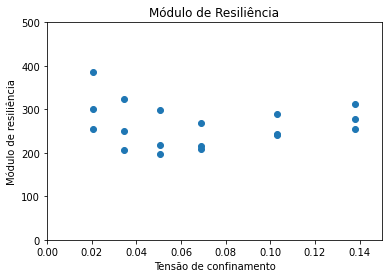

In [7]:
fig = plt.figure()
plt.scatter(df.filter(items=['s3 (Mpa)']), df.filter(items=['MR (Mpa)']), vmin=100)
#plt.plot(x, regressor.predict(x), color='red')
plt.title('Módulo de Resiliência')
plt.xlabel('Tensão de confinamento')
plt.ylabel('Módulo de resiliência')
plt.xlim(0,0.15)
plt.ylim(0,500)

(0.0, 500.0)

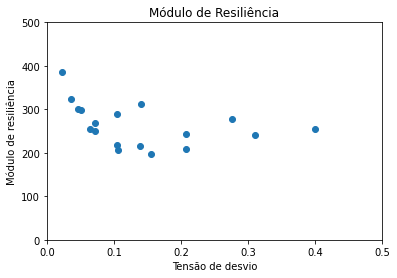

In [8]:
fig = plt.figure()
plt.scatter(df.filter(items=['sd (Mpa)']), df.filter(items=['MR (Mpa)']), vmin=100)
#plt.plot(x, regressor.predict(x), color='red')
plt.title('Módulo de Resiliência')
plt.xlabel('Tensão de desvio')
plt.ylabel('Módulo de resiliência')
plt.xlim(0, 0.5)
plt.ylim(0, 500)

Preparação para regressão potêncial

In [9]:
#transformação dos parâmetros de entrada para a base ln
ln_mr_list = list()
ln_e_list = list()
ln_s3_list = list()
ln_sd_list = list()
ln_oct_list = list()
for i in df.index:
    ln_mr = log(float(df['MR (Mpa)'][i]))
    ln_e = log(float(df['e'][i]))
    ln_s3 = log(float(df['s3 (Mpa)'][i]))
    ln_sd = log(float(df['sd (Mpa)'][i]))
    ln_oct = log(float(df['oct (mpa)'][i]))
    ln_mr_list.append(ln_mr)
    ln_e_list.append(ln_e)
    ln_s3_list.append(ln_s3)
    ln_sd_list.append(ln_sd)
    ln_oct_list.append(ln_oct)
df['ln_mr'] = ln_mr_list
df['ln_e'] = ln_e_list
df['ln_s3'] = ln_s3_list
df['ln_sd'] = ln_sd_list
df['ln_oct'] = ln_oct_list

In [10]:
df

,s3 (Mpa),Carga (kgf),LVDT-A (mm),LVDT-B (mm),e,sd (Mpa),oct (mpa),MR (Mpa),ln_mr,ln_e,ln_s3,ln_sd,ln_oct
0,0.0207,17.88,0.011142,0.012061,0.000058,0.022333,0.084433,385.001562,5.953247,-9.754938,-3.877622,-3.801691,-2.471797
1,0.0207,36.50,0.028317,0.032436,0.000152,0.045590,0.107690,300.167905,5.704342,-8.792403,-3.877622,-3.088061,-2.228496
2,0.0207,50.86,0.045420,0.054234,0.000249,0.063527,0.125627,254.988584,5.541219,-8.297516,-3.877622,-2.756297,-2.074441
3,0.0345,29.10,0.020936,0.023896,0.000112,0.036347,0.139847,324.297069,5.781660,-9.096295,-3.366796,-3.314635,-1.967204
4,0.0345,56.89,0.051595,0.062099,0.000284,0.071058,0.174558,249.998559,5.521455,-8.165709,-3.366796,-2.644254,-1.745496
5,0.0345,84.84,0.092686,0.112963,0.000514,0.105969,0.209469,206.116697,5.328443,-7.573049,-3.366796,-2.244606,-1.563178
6,0.0504,41.10,0.031014,0.037529,0.000171,0.051336,0.202536,299.583459,5.702393,-8.671759,-2.987764,-2.969366,-1.596838
7,0.0504,83.11,0.084596,0.105022,0.000474,0.103808,0.255008,218.984229,5.389000,-7.654208,-2.987764,-2.265209,-1.366459
8,0.0504,124.85,0.142363,0.173639,0.000790,0.155944,0.307144,197.395766,5.285211,-7.143471,-2.987764,-1.858261,-1.180440
9,0.0689,57.10,0.048685,0.057380,0.000265,0.071321,0.278021,268.969558,5.594598,-8.235168,-2.675099,-2.640570,-1.280060


In [11]:
#regressão linear dos parâmetro na base ln
y_e = df.iloc[:, 9].values
y_mr = df.iloc[:, 8].values

In [12]:
x_s3 = df.iloc[:, 10].values
x_s3 = x_s3.reshape(-1,1)
x_sd = df.iloc[:, 11].values
x_sd = x_sd.reshape(-1,1)
x_oct = df.iloc[:, 12].values
x_oct = x_oct.reshape(-1,1)
x_comp = df.iloc[:, 10:12].values

In [13]:
from sklearn.linear_model import LinearRegression
regressor_s3 = LinearRegression()
regressor_sd = LinearRegression()
regressor_oct = LinearRegression()
regressor_comp = LinearRegression()
regressor_s3.fit(x_s3, y_mr)
regressor_sd.fit(x_sd, y_e)
regressor_oct.fit(x_oct, y_mr)
regressor_comp.fit(x_comp, y_e)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Regressão com k3 e k4 iguais a zero

In [14]:
k1_s3 = regressor_s3.intercept_
k2 = regressor_s3.coef_[0]

In [15]:
print(f'Interseção:{k1_s3}, Variável X1:{k2}')

Interseção:5.425703531844281, Variável X1:-0.04696997295331014


Regressão com k2 e k4 iguais a zero

In [16]:
k1_sd = regressor_sd.intercept_
k3 = regressor_sd.coef_[0]

In [17]:
print(f'Interseção:{k1_sd}, Variável X1:{k3}')

Interseção:-5.260094063315589, Variável X1:1.1339580636220585


Regressão com k2 e k3 iguais a zero

In [18]:
k1_oct = regressor_oct.intercept_
k4 = regressor_oct.coef_[0]

In [19]:
print(f'Interseção:{k1_oct}, Variável X1:{k4}')


Interseção:5.43989427753686, Variável X1:-0.09565027404390317


Regressão do modelo composto com k4 igual a zero

In [20]:
k1_comp = regressor_comp.intercept_
k2_comp = regressor_comp.coef_[0]
k3_comp = regressor_comp.coef_[1]

In [21]:
print(f'Interseção:{k1_comp}, Variável X1:{k2_comp}, Variável X2:{k3_comp}')

Interseção:-5.582096317776629, Variável X1:-0.24191591364873088, Variável X2:1.2991835658162438


Tranformação para parâmetros potênciais

In [22]:
#modelo dependente da tensão de confinamento
K1_s3 = float(exp(k1_s3))
K2 = k2

In [23]:
print(f'MR = {K1_s3}*s3^{K2:.4}')

MR = 227.17111222003487*s3^-0.04697


In [24]:
#modelo dependente da tensão desvio
K1_sd = 1/exp(k1_sd)
K3 = 1-k3

In [25]:
print(f'MR = {K1_sd}*sd^{K3:.4}')

MR = 192.49959759606244*sd^-0.134


In [26]:
#modelo dependente do invariante de tensões
K1_oct = exp(k1_oct)
K4 = k4

In [27]:
print(f'MR = {K1_oct}*oct^{K4:.4}')

MR = 230.4178218332036*oct^-0.09565


In [28]:
#modelo composto
K1_comp = 1/exp(k1_comp)
K2_comp = -k2_comp
K3_comp = 1-k3_comp

In [29]:
print(f'MR = {K1_comp}*s3^{K2_comp:.4}*sd^{K3_comp:.4}')

MR = 265.6278629476959*s3^0.2419*sd^-0.2992
